In [334]:
import time
start = time.time()

In [335]:
#IMPORTS
from datetime import datetime
from pyspark.ml.fpm import PrefixSpan
from pyspark.sql import Row
import pyspark.sql.functions as F
from math import sin, cos, sqrt, atan2, radians 
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import operator

In [ ]:
#parameters
interval=30 #time window
maxDelta=3 #how many spatial delta
th=1 #distance
window_size=3 #how many time delta
support=0

In [336]:
#FILES
inputPath  = "file:///home/bigdata-01QYD/s270240/bike_sharing/filtered_status.csv"
STATION_PATH="file:///home/bigdata-01QYD/s270240/bike_sharing/station.csv"

#OUTPUT FILES
folder_path = f'./Results_extraction/Time_slots_Empty_almostEmpty/Time_slots_Empty_almostEmpty_{interval}_{int(th*1000)}_{support_str}({window_size}-{maxDelta})'
output_file_conf1=f'{folder_path}/results_6-10_ordered_by_confidence.txt'
output_file_conf2=f'{folder_path}/results_10-14_ordered_by_confidence.txt'
output_file_conf3=f'{folder_path}/results_14-17_ordered_by_confidence.txt'
output_file_conf4=f'{folder_path}/results_17-20_ordered_by_confidence.txt'
output_file_conf5=f'{folder_path}/results_20-24_ordered_by_confidence.txt'
output_file_conf6=f'{folder_path}/results_0-6_ordered_by_confidence.txt'

output_file_sup1=f'{folder_path}/results_6-10_ordered_by_support.txt'
output_file_sup2=f'{folder_path}/results_10-14_ordered_by_support.txt'
output_file_sup3=f'{folder_path}/results_14-17_ordered_by_support.txt'
output_file_sup4=f'{folder_path}/results_17-20_ordered_by_support.txt'
output_file_sup5=f'{folder_path}/results_20-24_ordered_by_support.txt'
output_file_sup6=f'{folder_path}/results_0-6_ordered_by_support.txt'

img_confidence1=f'{folder_path}/6-10_(3-3)_0.jpg'
img_confidence2=f'{folder_path}/10-14_(3-3)_0.jpg'
img_confidence3=f'{folder_path}/14-17_(3-3)_0.jpg'
img_confidence4=f'{folder_path}/17-20_(3-3)_0.jpg'
img_confidence5=f'{folder_path}/20-24_(3-3)_0.jpg'
img_confidence6=f'{folder_path}/0-6_(3-3)_0.jpg'


In [337]:
inputDF = spark.read.format("csv")\
.option("delimiter", ",")\
.option("header", True)\
.option("inferSchema", True).load(inputPath)

In [338]:
inputDF=inputDF.filter("bikes_available is not null")

In [340]:
#filter for these fields
filteredDF = inputDF.filter("docks_available<>0 OR bikes_available<>0")

In [341]:
#determine if the station is empty or almost empty
def stateFunction(docks_available,bikes_available):
    if bikes_available==0:
        return 1
    elif (bikes_available==1 or bikes_available==2):
        return 0
    else:
        return 2

In [342]:
spark.udf.register("state", stateFunction)

<function __main__.stateFunction(docks_available, bikes_available)>

In [343]:
def getInt(station):
    return (station)

In [344]:
spark.udf.register("intValue", getInt)

<function __main__.getInt(station)>

In [345]:
getStatusDF = filteredDF.selectExpr("station_id","time", "state(docks_available,bikes_available) as status")

In [346]:
#getStatusDF.show(100,False)

In [347]:
#filter only empty or almost empty stations
empty_almostEmpty=getStatusDF.filter("status==1  or status==0")

In [348]:
empty_almostEmpty_count = empty_almostEmpty.count()

In [349]:
empty_almostEmpty_count/getStatusDF.count()*100

4.5998904386081785

In [350]:
empty_almostEmpty.describe().show()

+-------+------------------+-------------------+
|summary|        station_id|             status|
+-------+------------------+-------------------+
|  count|           3310905|            3310905|
|   mean| 50.45948887086763|0.15936579273642704|
| stddev|21.197140022611265| 0.3660169084956111|
|    min|                 2|                  0|
|    max|                84|                  1|
+-------+------------------+-------------------+



In [351]:
#create a view
empty_almostEmpty.createOrReplaceTempView("readings")

In [352]:
#select station, year, month, day, hour, minute, status ordered by time
ss=spark.sql("""SELECT  station_id , YEAR(time) as year, MONTH(time) as month, DAY(time) as day, HOUR(time)as hour, MINUTE(time) as minute, status
FROM readings
GROUP BY station_id, year, month, day,hour,minute, status
ORDER BY  station_id,year, month,day, hour,minute
""")

In [353]:
#create rdd and group into interval
my_rdd=ss.rdd.map(tuple)
rdd=my_rdd.map(lambda line: (line[0],line[1],line[2], line[3], line[4], int(line[5]/interval), line[6])).distinct()
# rdd.collect()

# [(4, 2014, 7, 25, 17, 0, '0'),
#  (4, 2014, 8, 30, 19, 0, '0'),
#  (36, 2015, 2, 19, 9, 0, '0'),
#  (36, 2015, 7, 31, 3, 1, '0'),
#  (37, 2013, 9, 10, 17, 1, '0'),
#  (37, 2013, 10, 21, 15, 1, '0'),
#  (37, 2013, 12, 11, 0, 0, '0'), ... ]

In [354]:
#get distinct stations to calculate distances
id_stations=rdd.map(lambda line: line[0]).distinct()

In [355]:
tot_id_stations=id_stations.collect()

In [356]:
#list of all stations
#tot_id_stations

In [357]:
#obtain timestamp and info
def getMap(line):
    id_station=str(line[0])
    year=int(line[1])
    month=int(line[2])
    day=int(line[3])
    hour=int(line[4])
    minute=int(line[5])   
    timestamp= datetime(year,month, day, hour, minute)  
    status=int(line[6])
    if status==0:
        status='QuasiVuota'
    else:
        status='Vuota'
    info=id_station.split('.')[0]+'_'+status
    return ( (timestamp,info))

In [358]:
get_map=rdd.map(getMap)
# get_map.collect()

# [(datetime.datetime(2014, 4, 18, 14, 1), '10_QuasiVuota'),
#  (datetime.datetime(2014, 6, 12, 14, 1), '10_Vuota'),
#  (datetime.datetime(2014, 7, 30, 13, 1), '10_Vuota'),
#  (datetime.datetime(2015, 3, 17, 11, 1), '30_QuasiVuota'),
#  (datetime.datetime(2014, 1, 1, 12, 0), '31_QuasiVuota'),
#  (datetime.datetime(2014, 2, 20, 9, 0), '42_QuasiVuota'), ...]

In [359]:
#for each timestamp obtain info
reduceK=get_map.reduceByKey(lambda l1,l2 :(l1+','+l2)).sortByKey()
# reduceK.collect()

# [(datetime.datetime(2013, 8, 29, 10, 0), '7_Vuota,2_QuasiVuota,4_Vuota,16_QuasiVuota,70_QuasiVuota,13_Vuota,70_Vuota,67_QuasiVuota,67_Vuota,59_QuasiVuota,6_QuasiVuota'),
#  (datetime.datetime(2013, 8, 29, 10, 1), '73_QuasiVuota,13_QuasiVuota,69_QuasiVuota,59_QuasiVuota,7_Vuota,2_QuasiVuota,13_Vuota,67_Vuota,7_QuasiVuota,67_QuasiVuota,70_QuasiVuota,16_QuasiVuota,4_Vuota'),
#  (datetime.datetime(2013, 8, 29, 11, 0), '70_QuasiVuota,69_QuasiVuota,73_QuasiVuota,4_Vuota,4_QuasiVuota,67_Vuota,67_QuasiVuota,2_QuasiVuota,16_QuasiVuota'),
#  (datetime.datetime(2013, 8, 29, 11, 1), '73_QuasiVuota,16_QuasiVuota,2_QuasiVuota,67_QuasiVuota,69_QuasiVuota'), ...]

In [360]:
#divide rdd in different time slots
slot1= reduceK.filter(lambda line : line[0].hour >=6 and line[0].hour<10)
slot2= reduceK.filter(lambda line : line[0].hour >=10 and line[0].hour<14)
slot3= reduceK.filter(lambda line : line[0].hour >=14 and line[0].hour<17)
slot4= reduceK.filter(lambda line : line[0].hour >=17 and line[0].hour<20)
slot5= reduceK.filter(lambda line : line[0].hour >=20 and line[0].hour<=23)
slot6= reduceK.filter(lambda line : line[0].hour >=0 and line[0].hour<6)

#create a list contaning all slots rdd
slots = [slot1, slot2, slot3, slot4, slot5, slot6]

# slots[0].collect()

In [361]:
my_df_list =[]

for slot in slots:
    my_df_list.append(slot.toDF())

# my_df_list[0].collect()

In [362]:
for i, my_df in enumerate(my_df_list):
    my_df.createOrReplaceTempView(f"view{i}")

In [363]:
add_rows_list = []
for i in range(0,len(my_df_list)):
    s2 = spark.sql(f"""SELECT ROW_NUMBER() OVER(ORDER BY _1,_2) as id ,_1, _2
                FROM view{i} """)
    add_rows_list.append(s2)


In [364]:
#identifier of the timestamp, info
rdd_scheme_list = []
for s2 in add_rows_list:
    rdd_scheme=s2.rdd.map(tuple).map(lambda line: (line[0], line[2]))
    rdd_scheme_list.append(rdd_scheme)

# rdd_scheme_list[0].collect()

# [(1, '16_QuasiVuota,57_QuasiVuota,68_QuasiVuota,63_QuasiVuota,2_QuasiVuota'),
#  (2, '2_QuasiVuota,16_QuasiVuota,63_QuasiVuota,68_QuasiVuota'),
#  (3, '68_QuasiVuota,16_QuasiVuota,63_QuasiVuota,2_QuasiVuota,50_QuasiVuota'),
#  (4, '2_QuasiVuota,16_QuasiVuota,68_QuasiVuota,50_QuasiVuota,63_QuasiVuota'),
#  (5,
#   '68_QuasiVuota,16_QuasiVuota,63_QuasiVuota,2_QuasiVuota,50_QuasiVuota,70_Vuota,70_QuasiVuota'),, ...]

In [365]:
#obtain window, station-status
def giveSplit(line):   
    id_window=( int(line[0] ))
    lista=[]    
    counter=id_window    
    while counter>=1:
        lista.append(('Window '+str(counter),(line[1])))
        counter=counter-1
        if (id_window-counter)==window_size:
            return lista  
    return lista

In [366]:
mapData_list = []

for rdd_scheme in rdd_scheme_list:
    mapData=rdd_scheme.flatMap(giveSplit)
    mapData_list.append(mapData)

    
# mapData_list[0].collect()

# [('Window 1', '16_QuasiVuota,57_QuasiVuota,68_QuasiVuota,63_QuasiVuota,2_QuasiVuota'),
#  ('Window 2', '2_QuasiVuota,16_QuasiVuota,63_QuasiVuota,68_QuasiVuota'),
#  ('Window 1', '2_QuasiVuota,16_QuasiVuota,63_QuasiVuota,68_QuasiVuota'),
#  ('Window 3', '68_QuasiVuota,16_QuasiVuota,63_QuasiVuota,2_QuasiVuota,50_QuasiVuota'),
#  ('Window 2', '68_QuasiVuota,16_QuasiVuota,63_QuasiVuota,2_QuasiVuota,50_QuasiVuota'),
#  ('Window 1', '68_QuasiVuota,16_QuasiVuota,63_QuasiVuota,2_QuasiVuota,50_QuasiVuota'),
#  ('Window 4', '2_QuasiVuota,16_QuasiVuota,68_QuasiVuota,50_QuasiVuota,63_QuasiVuota'), ...]

In [367]:
# for each window get all info
all_keys_list = []

for mapData in mapData_list:
    all_keys=mapData.reduceByKey(lambda l1,l2:(l1+'-'+l2))    
    all_keys_list.append(all_keys)


In [368]:
# all_keys_list[0].collect()

# [('Window 1',
#   '16_QuasiVuota,57_QuasiVuota,68_QuasiVuota,63_QuasiVuota,2_QuasiVuota-2_QuasiVuota,16_QuasiVuota,63_QuasiVuota,68_QuasiVuota-68_QuasiVuota,16_QuasiVuota,63_QuasiVuota,2_QuasiVuota,50_QuasiVuota'),
#  ('Window 2',
#   '2_QuasiVuota,16_QuasiVuota,63_QuasiVuota,68_QuasiVuota-68_QuasiVuota,16_QuasiVuota,63_QuasiVuota,2_QuasiVuota,50_QuasiVuota-2_QuasiVuota,16_QuasiVuota,68_QuasiVuota,50_QuasiVuota,63_QuasiVuota'),
#  ('Window 3',
#   '68_QuasiVuota,16_QuasiVuota,63_QuasiVuota,2_QuasiVuota,50_QuasiVuota-2_QuasiVuota,16_QuasiVuota,68_QuasiVuota,50_QuasiVuota,63_QuasiVuota-68_QuasiVuota,16_QuasiVuota,63_QuasiVuota,2_QuasiVuota,50_QuasiVuota,70_Vuota,70_QuasiVuota'),
 #  ... ]

In [369]:
#finestra temporale
def reduceKeys(line):   
    lista=[]
    #lista.append(line[0])
    line_split=line[1].split("-")
    #return line_split[0]
    count=len(line_split)
    tot=[]
    for val in range(count):
        li=[]
        stations=line_split[val].split(',')
        for st in stations:
            all_string_st=st.split('_')[0]+'_'+'T'+str(val)+'_'+st.split('_')[1]
            li.append(all_string_st)
        tot.append(li)
    lista.append((line[0],(tot))) 
    return lista

In [370]:
windows_list = []

for all_keys in all_keys_list:
    windows=all_keys.flatMap(reduceKeys)
    windows_list.append(windows)

In [371]:
# windows_list[0].collect()

#  [('Window 1',
#   [['16_T0_QuasiVuota', '57_T0_QuasiVuota', '68_T0_QuasiVuota', '63_T0_QuasiVuota', '2_T0_QuasiVuota'],
#    ['2_T1_QuasiVuota', '16_T1_QuasiVuota', '63_T1_QuasiVuota', '68_T1_QuasiVuota'],
#    ['68_T2_QuasiVuota', '16_T2_QuasiVuota', '63_T2_QuasiVuota', '2_T2_QuasiVuota', '50_T2_QuasiVuota']]),
#  ('Window 2',
#   [['2_T0_QuasiVuota', '16_T0_QuasiVuota', '63_T0_QuasiVuota', '68_T0_QuasiVuota'],
#    ['68_T1_QuasiVuota', '16_T1_QuasiVuota', '63_T1_QuasiVuota', '2_T1_QuasiVuota', '50_T1_QuasiVuota'],
#    ['2_T2_QuasiVuota', '16_T2_QuasiVuota', '68_T2_QuasiVuota', '50_T2_QuasiVuota', '63_T2_QuasiVuota']]), ...]


In [372]:
#save station file
stationsDF = spark.read.format("csv")\
.option("delimiter", ",")\
.option("header", True)\
.option("inferSchema", True).load(STATION_PATH)

In [373]:
#get only rows interested: only the used stations 
necessary_rows=stationsDF.filter(F.col("id").isin(tot_id_stations)).sort("id").rdd.map(tuple)

In [374]:
#necessary_rows.collect()

In [375]:
#get info of stations about coordinates and name
coordinates=necessary_rows.map(lambda line: (line[0],(str(line[2])+','+str(line[3]))))
names_stations=necessary_rows.map(lambda line: (line[0],line[1]))

In [376]:
list_coo=coordinates.collect()
# list_coo

# [(2, '37.329732,-121.90178200000001'),
#  (3, '37.330698,-121.888979'),
#  (4, '37.333988,-121.894902'),
#  (5, '37.331415,-121.8932'), ...]

In [377]:
#create a dictionary in which the key is the station and value is the info about coordinates
dic_co=coordinates.collectAsMap()
dic_coordinates=sc.broadcast(dic_co)
#dic_coordinates.value

In [378]:
#function to retrieve distance between 2 stations
def getDistance(station1,station2):
    # approximate radius of earth in km
    R = 6373.0    
    lat_a=float(station1.split(',')[0])
    lat_b=float(station2.split(',')[0])
    long_a=float(station1.split(',')[1])
    long_b=float(station2.split(',')[1])
    
    lat1=radians(lat_a)
    lat2=radians(lat_b)
    lon1=radians(long_a)
    lon2=radians(long_b)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [379]:
#voc in which the key is a pair of stations and value is the distance
voc_distances={}
for i in range(len(list_coo)):
    for j in range(i+1,len(list_coo)):
        station1=list_coo[i][0]
        station2=list_coo[j][0]
        d_i=list_coo[i][1]
        d_j=list_coo[j][1]
        distance=getDistance(d_i,d_j)
        id_stations=str(station1)+' '+str(station2)
        voc_distances[id_stations]=distance

In [380]:
voc_distances['2 3']

1.1374454650255135

In [381]:
#voc_distances

In [382]:
#Applicazione “Delta Spaziale”
def giveSpatialWindow(line):
    lista=[]    
    time0=line[1][0]    
    dic={}
    
    count_windows=len(line[1])#tot windows

    for station in time0:# only first window
        act_station=int(station.split('_')[0])
        #lista_station=[] 
        list_tmp=[]
        
        #for each window
        for i,window in enumerate(line[1]):           
            second_lista=[]
            #for each element of a window
            for all_el in window :
                #second_lista=[]
                act_all_el=int(all_el.split('_')[0])
                state=all_el.split('_')[2]
               
                if act_station!=act_all_el:
                    
                    key=''
                    if act_station<act_all_el:
                        key=str(act_station)+' '+str(act_all_el)
                    else:
                        key=str(act_all_el)+' '+str(act_station)                    
                    
                    dist=voc_distances[key]
                    if dist<=maxDelta*th:
                        delta=0
                        for d in range(1,maxDelta+1):
                            if d*th>=dist:
                                delta=d
                                break                        
                        string=state+'_'+'T'+str(i)+'_'+str(delta)
                        second_lista.append(string)
                else:
                    string=state+'_'+'T'+str(i)+'_'+str(0)
                    second_lista.append(string)
                    
            if len(second_lista)>0:
                list_tmp.append(second_lista)
        lista.append(((line[0]+'|'+str(act_station)),list_tmp))
    
    return lista

In [383]:
spatial_app_list = []

for i, windows in enumerate(windows_list):
    spatial_app=windows.flatMap(giveSpatialWindow)
    print(f"num elements in slot{i+1}: {spatial_app.count()}")
    spatial_app_list.append(spatial_app)

num elements in slot1: 39213
num elements in slot2: 21509
num elements in slot3: 31358
num elements in slot4: 22018
num elements in slot5: 17456
num elements in slot6: 30368


In [384]:
# spatial_app_list[0].collect()

# [('Window 1|16',
#   [['QuasiVuota_T0_0', 'QuasiVuota_T0_3'],
#    ['QuasiVuota_T1_3', 'QuasiVuota_T1_0'],
#    ['QuasiVuota_T2_0', 'QuasiVuota_T2_3']]),
#  ('Window 1|57',
#   [['QuasiVuota_T0_0', 'QuasiVuota_T0_1', 'QuasiVuota_T0_1'],
#    ['QuasiVuota_T1_1', 'QuasiVuota_T1_1'],
#    ['QuasiVuota_T2_1', 'QuasiVuota_T2_1', 'QuasiVuota_T2_2']]),
#  ('Window 1|68',
#   [['QuasiVuota_T0_1', 'QuasiVuota_T0_0', 'QuasiVuota_T0_1'],
#    ['QuasiVuota_T1_1', 'QuasiVuota_T1_0'],
#    ['QuasiVuota_T2_0', 'QuasiVuota_T2_1', 'QuasiVuota_T2_2']]), ...]

In [385]:
def row_seq(line):
    true=line[1]
    string=Row(sequence=true)
    return string

In [386]:
spatial_list = []

for spatial_app in spatial_app_list:
    spatial=spatial_app.map(row_seq)
    spatial_list.append(spatial)

In [387]:
#create dataframes
df_list = []

for i, spatial in enumerate(spatial_list):
    df=spatial.toDF()
    print (f"num elements in df{i+1}: {df.count()}")
    df_list.append(df)

num elements in df1: 39213
num elements in df2: 21509
num elements in df3: 31358
num elements in df4: 22018
num elements in df5: 17456
num elements in df6: 30368


In [388]:
df_list[0].show(20,False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|sequence                                                                                                                                                                                                |
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[[QuasiVuota_T0_0, QuasiVuota_T0_3], [QuasiVuota_T1_3, QuasiVuota_T1_0], [QuasiVuota_T2_3, QuasiVuota_T2_0]]                                                                                            |
|[[QuasiVuota_T0_0, QuasiVuota_T0_1, QuasiVuota_T0_1], [QuasiVuota_T1_0, QuasiVuota_T1_1], [QuasiVuota_T2_0, QuasiVuota_T2_1, QuasiVuota_T2_1]]                                             

In [389]:
#prefixspan to obtain sequence and frequence
prefix_list = []
len_prefix_list = []
for df in df_list:
    print(support)
    prefixSpan = PrefixSpan(minSupport=support, maxPatternLength=5,
                        maxLocalProjDBSize=5000)
    prefix=prefixSpan.findFrequentSequentialPatterns(df)   
    prefix_list.append(prefix)
    len_prefix=prefix.count()    
    prefix.show(len_prefix,False)
    len_prefix_list.append(len_prefix)

0


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [390]:
len_prefix_list[0]

101579

In [391]:
pre_list = []

for prefix in prefix_list:
    pre=prefix.rdd.map(tuple)
    pre_list.append(pre)

In [392]:
# pre_list[0].collect()

# [([['QuasiVuota_T2_1']], 23213),
#  ([['Vuota_T1_3']], 13208),
#  ([['QuasiVuota_T1_3']], 21936),
#  ([['Vuota_T0_1']], 14966),
#  ([['Vuota_T1_2']], 18723),
#  ([['Vuota_T2_0']], 7973), ... ]

In [393]:
def giveSelected(line):
    seq=line[0]
    found=False   
    for window in seq:
        for el in window:
            if 'T0' in el and '_0' in el:
                found=True
                break
    return found 

In [394]:
giveT0_list = []

for pre in pre_list:
    giveT0=pre.filter(giveSelected)
    giveT0_list.append(giveT0)

In [395]:
# giveT0_list[0].collect()

# [([['Vuota_T0_0']], 18616),
#  ([['QuasiVuota_T0_0']], 37673),
#  ([['QuasiVuota_T0_2', 'Vuota_T0_0']], 15842),
#  ([['QuasiVuota_T0_0'], ['QuasiVuota_T1_0']], 24871),
#  ([['QuasiVuota_T0_0', 'QuasiVuota_T0_1']], 23700),
#  ([['QuasiVuota_T0_0'], ['Vuota_T1_3']], 12726), ...]

In [396]:
# df2=giveT0.toDF().withColumnRenamed('_1','sequence')
# df2=df2.withColumnRenamed('_2','freq')#.show(len_prefix,False)

In [397]:
def mapValues(line):
    seq=line[0]
    final=''
    #voc[seq]=line[1]
    for i,window in enumerate(seq):
        if i>0:
            final+='-'
        for j,el in enumerate(window):
            if j>0:
                final+=','
            final+=el
    final+=(';'+str(line[1])+';'+str(i))
    return final  

In [398]:
mapDict_list = []

for giveT0 in giveT0_list:
    mapDict=giveT0.map(mapValues)
    mapDict_list.append(mapDict)

In [399]:
# mapDict_list[0].collect()

# ['Vuota_T0_0;18616;0',
#  'QuasiVuota_T0_0;37673;0',
#  'QuasiVuota_T0_2,Vuota_T0_0;15842;0',
#  'QuasiVuota_T0_0-QuasiVuota_T1_0;24871;1',
#  'QuasiVuota_T0_0,QuasiVuota_T0_1;23700;0',
#  'QuasiVuota_T0_0-Vuota_T1_3;12726;1', ...]

In [400]:
li_list =[]

for mapDict in mapDict_list:
    li=mapDict.collect()
    li_list.append(li)
    

In [401]:
voc_list = []
for li in li_list:
    voc={}
    for el in li:
        splits=el.split(';')
        voc[splits[0]]=int(splits[1])
    voc_list.append(voc)
         

In [402]:
# voc_list[0]

# {'Vuota_T0_0': 18616,
#  'QuasiVuota_T0_0': 37673,
#  'QuasiVuota_T0_2,Vuota_T0_0': 15842,
#  'QuasiVuota_T0_0-QuasiVuota_T1_0': 24871,
#  'QuasiVuota_T0_0,QuasiVuota_T0_1': 23700, ...]

In [403]:
repeated_list = []

for voc in voc_list:
    repeated_el_window=0
    for el in voc.keys():
        flag_rep=False
        windows=el.split('-')
        for w in windows:
            tot_items=len(w.split(','))
            set_items=len(set(w.split(',')))
            if tot_items!=set_items:
                repeated_el_window+=1
                break
    repeated_list.append(repeated_el_window)
    
repeated_list[0]

9900

In [404]:
voc_supports_list = []
keys_list = []
values_list = []

for voc in voc_list:
    voc_supports={}
    for el in voc.keys():    
        if len(el.split('-'))>1:        
            num=int(voc[el])       
            string=''
            tot=el.split('-')[:-1]
            for k,station in enumerate(tot):
                if k>0:
                    string+='-'
                string+=station
            #print(string)
            den=int(voc[string])
            voc_supports[el]=str(num/den)+' - '+str(voc[el])
    voc_supports_list.append(voc_supports)
#     keys=list(voc_supports.keys())
#     keys_list.append(keys)
#     values=list(voc_supports.values())
#     values_list.append(values)

In [405]:
# #sort vocabulary by decreasing values and sort within each window
# for voc_supports in voc_supports_list:
#     for key in voc_supports:    
#         splitted=key.split('-')      
#         splitted.sort()
#     # voc_supports = dict(sorted(voc_supports.items(), key=operator.itemgetter(1),reverse=True))
#     global voc_supports = dict(sorted(voc_supports.items(), 
#                                key=lambda v: (float(v[1].split(' - ')[0]), int(v[1].split(' - ')[1])),
#                                reverse=True))

In [406]:
# voc_supports_list[0]

In [407]:

for i, voc_supports in enumerate(voc_supports_list):
    
    #sort vocabulary by decreasing values of confidence
    voc_supports = dict(sorted(voc_supports.items(), 
                               key=lambda v: (float(v[1].split(' - ')[0]), int(v[1].split(' - ')[1])),
                               reverse=True))
    
    save file ordered by confidence
    file = open(eval("output_file_conf"+str(i+1)), "w")
    list_pattern=[]
    for el in voc_supports:
        key_list=[]
        for e in el.split('-'):
            key_list.append([e])
        list_pattern.append([[key_list], [voc_supports[el]]])
    file.write('TIME SLOT: ' + eval("output_file_conf"+str(i+1)).split('_')[1] + ' Pattern, Confidence-Frequence'+'\n')
    file.write(f'Total number of input patterns: {len(voc_supports)}'+'\n')
    for el in list_pattern:  
        file.write(str(el)+ '\n')    
    file.close()
    
    save file ordered by support
    file1 = open(eval("output_file_sup"+str(i+1)), "w")
    #order list first by support and then by confidence
    list_ordered_by_support = sorted(list_pattern,
                                     key=lambda v: (int(v[1][0].split(" - ")[1]), float(v[1][0].split(" - ")[0])),
                                     reverse=True)
    file1.write('TIME SLOT: ' + eval("output_file_sup"+str(i+1)).split('_')[1] + ' Pattern, Confidence-Frequence'+ '\n')
    file1.write(f'Total number of input patterns: {len(voc_supports)}'+'\n')
    for el in list_ordered_by_support:  
        file1.write(str(el)+ '\n')    
    file1.close()

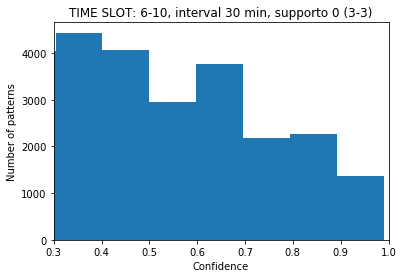

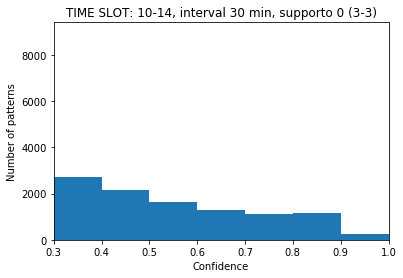

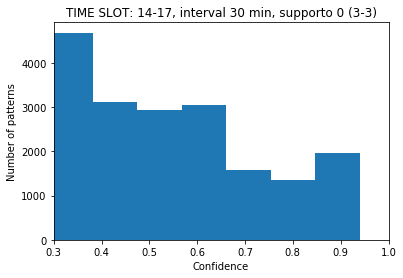

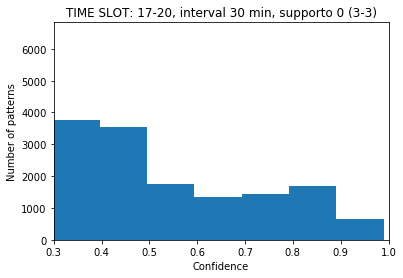

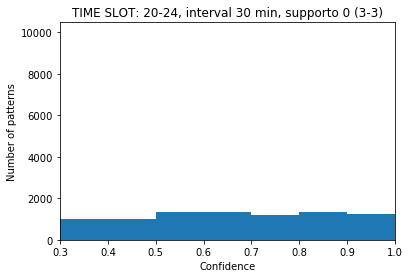

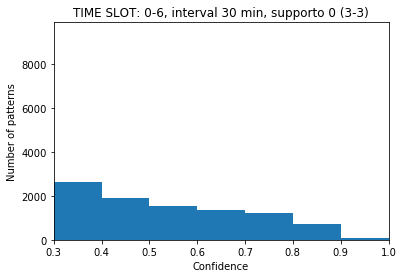

In [414]:
confidence_list = []

for i, voc_supports in enumerate(voc_supports_list): 
    confidence=[]
    for el in voc_supports.values():
        val=round(float(el.split(' - ')[0]),2)
        confidence.append(val)
    plt.hist(confidence)
    plt.xlabel('Confidence')
    plt.ylabel('Number of patterns')
    plt.title('TIME SLOT: ' + eval("output_file_conf"+str(i+1)).split('_')[1] + f', interval {interval} min, supporto {support} ({window_size}-{maxDelta})')
    plt.xlim(0.3,1)
    plt.savefig(eval("img_confidence"+str(i+1)))
    plt.show()


In [439]:
end = time.time()
print(f'The time of execution is: {end-start} s')

The time of execution is: 2811.8923947811127 s
